In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Basic PCA 

Want to pick up cultural differences from the COVID data

[read this](http://pmaweb.caltech.edu/~physlab/lab_21_current/Ph21_5_Covariance_PCA.pdf)


In [2]:
! ../.g

[master 52f555f] web
 6 files changed, 13 insertions(+)
 create mode 100644 PROG/.ipynb_checkpoints/Untitled2-checkpoint.ipynb
 create mode 100644 PROG/.ipynb_checkpoints/horned_sphere-checkpoint.png
 create mode 100644 PROG/.~lock.peter_data.xlsx#
 create mode 100644 PROG/Untitled2.ipynb
 create mode 100644 PROG/peter_data.xlsx
 create mode 100644 PROG/skills assement, fisher researcher, excel and powerpoint.xlsx
Counting objects: 7, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 883.68 KiB | 25.99 MiB/s, done.
Total 7 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   54425fb..52f555f  master -> master


In [3]:
import requests
import pandas as pd

In [4]:
root_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
fn = 'time_series_covid19_%s_global.csv'

for ss in ['deaths','confirmed']:
    r = requests.get(root_dir + fn%ss, allow_redirects=True)
    open('covid_%s.csv'%ss, 'wb').write(r.content)

In [10]:
df = pd.read_csv('covid_deaths.csv')

In [6]:
def ref2weeks(ref):
    X = df.iloc[ref][4:].values
    X = X[len(X) % 7  + 6:]
    X = np.diff(X,1).reshape((-1,7))
    return X.sum(axis=0)



In [7]:
ref4big[WX.sum(axis=1)/np.sqrt(7) <.995]

NameError: name 'ref4big' is not defined

In [8]:
df = df.drop([27,106])

In [11]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,1556,1558,1574,1577,1581,1591,1595,1605,1617,1626
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,557,559,571,579,590,598,605,612,623,631
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,2036,2048,2062,2077,2093,2111,2124,2139,2154,2168
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,75,75,75,75,75,75,75,75,76,76
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,303,307,308,308,312,315,317,322,322,324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,512,515,521,533,538,542,548,558,565,572
265,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
266,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,602,602,605,605,605,605,605,605,605,605
267,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,349,349,349,350,350,350,350,350,353,353


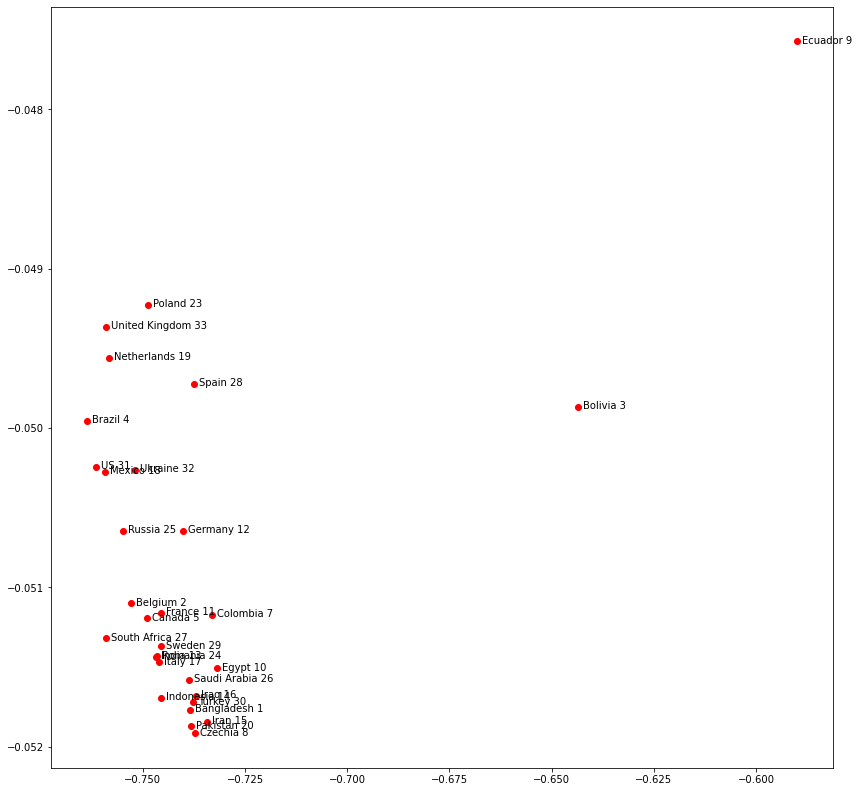

In [88]:
def mk_weeks(ii):
    WX = [ ref2weeks(ref) for ref in ref4big]
    #normalise
    return np.array([ x/np.linalg.norm(x) for x in WX]).astype(float)
    

ref4big = df[ df.iloc[:,-1] > 5000].index
idx = ref4big
WX = mk_weeks(idx)

if False:
    dirty = df.iloc[ref4big[WX.sum(axis=1)/np.sqrt(7) <.995],1].index

    idx = dirty.tolist()
    WX = mk_weeks(idx)


#calculate covariance
cov = np.dot(WX, WX.T) #- np.identity(len(WX))

#cov = -np.log(cov)

vp, vecs = np.linalg.eig(cov)

Xx = [ np.dot(vecs[0], u).real for u in cov]
Yx = [ .1*np.dot(vecs[1], u).real for u in cov]

fig, ax = plt.subplots()
fig.set_size_inches(14,14)
#ax.axis('off')


labels = df.iloc[idx,1]
kk = -1
for label , x, y  in zip(labels,Xx, Yx): 
    kk += 1
    #if label.split()[0].lower() in ['ecuador', 'china', 'bolivia']: continue
    if label.lower() in ['peru', 'chile', 'argentina', 'philippines']: continue
    if label.lower() in ['sudan','oman','tunisia']: continue 
    if label[0] == 'K':continue
    
    label += ' ' + str(kk)
  
    ax.plot([x], [y], 'ro');
    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(5,-2), # distance from text to points (x,y) : not same units
                 ha='left') # horizontal alignment can be left, right or center
    
    

In [85]:
ref4big = df[ df.iloc[:,-1] > 5000].index
ref4big
#np.dot(WX, WX.T)

Int64Index([  6,  20,  23,  27,  30,  50,  55,  89,  98, 106, 107, 126, 130,
            143, 144, 145, 146, 149, 178, 191, 199, 203, 204, 205, 208, 209,
            216, 226, 228, 232, 243, 244, 246, 258],
           dtype='int64')

In [89]:
cc = np.zeros_like(cov)
dd = np.zeros_like(cov)

cc[(cov > .995)] = 1
cc = cc - np.identity(cc.shape[0])

dd[cov > .98] = 1
dd = dd - np.identity(cc.shape[0])



for k, row in enumerate(cc):
    if sum(row) < 1: cc[k] = dd[k]

cc = cc + cc.T

cc[3] = 0
cc[:,3] =0

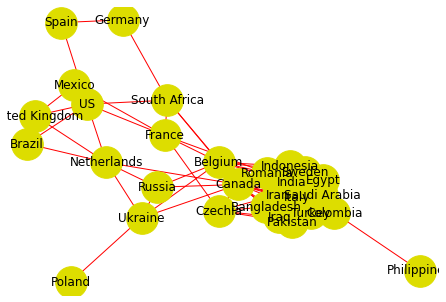

In [98]:
import networkx as nx

def show_graph(adjacency_matrix, my_labels=None):
    
    #rows, cols = np.where(adjacency_matrix == 1)
    #edges = zip(rows.tolist(), cols.tolist())
    edges = np.vstack( np.nonzero(adjacency_matrix) ).T
    gr = nx.Graph()
    gr.add_edges_from(edges)
    pos = nx.spring_layout(gr) 
   
    if my_labels == None:
        my_labels = {k : df.iloc[idx[k],1] for k in pos.keys()} 
    
        
    nx.draw(gr, pos, 
            node_size=1000,
            connectionstyle='arc3, rad = 0.1',
            node_color='#dddd00',
            edge_color="r",
            labels=my_labels,
            with_labels=True)

show_graph(cc)

In [313]:
cc[2]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 1.])

In [145]:
X, Y = np.where(cov > .997)
df.iloc[ ref4big[Y[np.where(X == 22)] ],1]
Y[np.where(X == 22)]

array([ 5,  9, 10, 11, 12, 13, 22])

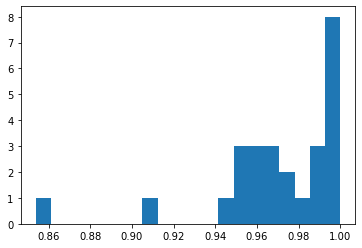

In [192]:
plt.hist(WX.sum(axis=1)/np.sqrt(7), bins = 20);

dirty = df.iloc[ref4big[WX.sum(axis=1)/np.sqrt(7) <.995],1].index

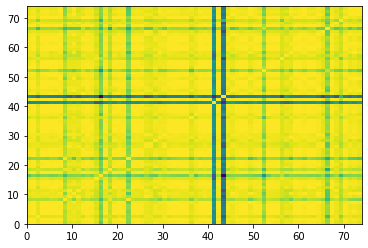

In [184]:
ref4big = df[ df.iloc[:,-1] > 1000 ].index.tolist()

WX = [ ref2weeks(ref) for ref in ref4big]
WX = np.array([ x/np.linalg.norm(x) for x in WX]).astype(float)
cov = np.dot(WX, WX.T)

plt.pcolor(cov);

(0.9830801115921854, 0.9934320256115639)

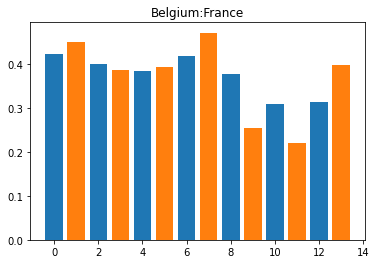

In [81]:
ref4big = np.array(ref4big)

tt = [1,7]
for k,ii in enumerate(tt):
    plt.bar(np.arange(k,7*len(tt),len(tt)), WX[ii]);
#plt.xticks()
plt.title(':'.join( df.iloc[ref4big[tt], 1]));
WX[tt[0]].dot(WX[tt[1]]), WX[tt[0]].sum()/np.sqrt(7)

In [67]:
np.linalg.norm(WX[8] - WX[21])

0.15522551789554961

In [290]:
pd.DataFrame( {'ref': np.arange(len(ref4big)), 'country':df.iloc[ref4big,1]} )

,ref,country
6,0,Argentina
23,1,Belgium
27,2,Bolivia
30,3,Brazil
55,4,Chile
89,5,Colombia
106,6,Ecuador
126,7,France
130,8,Germany
143,9,India


In [180]:
! ../.g


[master 302f546] web
 2 files changed, 497 insertions(+), 519 deletions(-)
 delete mode 100644 .stage_m2r_2020.tex.swp
 rewrite PROG/covid_pca.ipynb (86%)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 58.90 KiB | 11.78 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   869d8df..302f546  master -> master
